<a href="https://colab.research.google.com/github/behathenimru/BehaShirshekarMRP/blob/main/Beha_Shirshekar_MRP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install statsmodels


In [ ]:
import pandas as pd
import yfinance as yf


oil_raw = pd.read_csv('Sheet12-Table 1.csv')

oil_df = oil_raw[['Pricing Date', 'Day Close Price']].copy()
oil_df.columns = ['Date', 'Close']
oil_df['Date'] = pd.to_datetime(oil_df['Date'])
oil_df = oil_df.sort_values('Date').reset_index(drop=True)


oil_df['Open'] = oil_df['Close'].shift(1)


oil_df = oil_df.dropna().reset_index(drop=True)


oil_df['Oil_Price'] = (oil_df['Open'] + oil_df['Close']) / 2



start_date = oil_df['Date'].min().strftime('%Y-%m-%d')
end_date = oil_df['Date'].max().strftime('%Y-%m-%d')


fx_data = yf.download("USDCAD=X", start=start_date, end=end_date)
fx_data = fx_data[['Close']].reset_index()
fx_data.columns = ['Date', 'USD_CAD']



df = pd.merge(oil_df, fx_data, on='Date', how='inner')


print("Min:", df['Oil_Price'].min())
print("Max:", df['Oil_Price'].max())
print("Min:", df['USD_CAD'].min())
print("Max:", df['USD_CAD'].max())

df.to_csv("oil_fx_combined.csv", index=False)
print(df.head())

/tmp/ipython-input-4063432278.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  oil_df['Date'] = pd.to_datetime(oil_df['Date'])
/tmp/ipython-input-4063432278.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  fx_data = yf.download("USDCAD=X", start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Min: 12.559999999999999
Max: 121.81
Min: 1.2037999629974365
Max: 1.4716999530792236
        Date  Close   Open  Oil_Price  USD_CAD
0 2020-01-03  62.82  60.95     61.885  1.29830
1 2020-01-06  63.04  62.82     62.930  1.29866
2 2020-01-07  62.51  63.04     62.775  1.29639
3 2020-01-08  59.46  62.51     60.985  1.30031
4 2020-01-09  59.44  59.46     59.450  1.30365


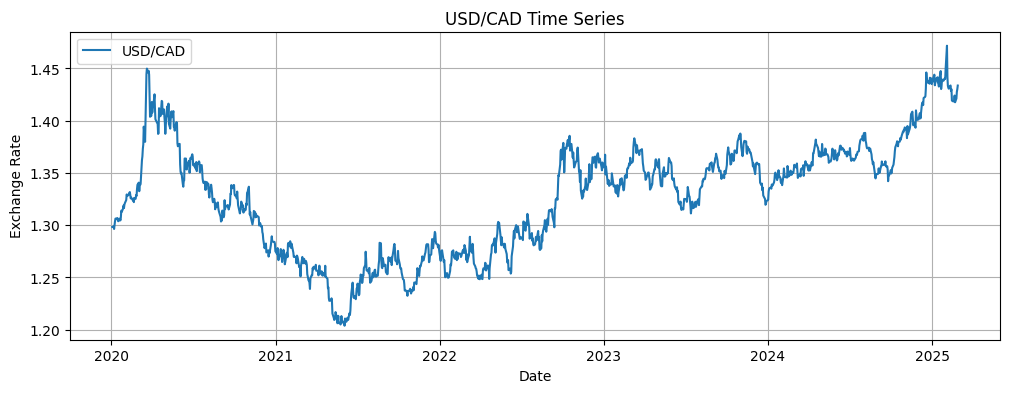


ADF Test on Original Series:
ADF Statistic: -1.3091358502762473
p-value: 0.6249823553046224
Critical Values:
   1%: -3.4352800041551514
   5%: -2.863717207316508
   10%: -2.567929152459942
=> Non-stationary (fail to reject H0)

ADF Test on First-Differenced Series:
ADF Statistic: -27.781523029882017
p-value: 0.0
Critical Values:
   1%: -3.4352800041551514
   5%: -2.863717207316508
   10%: -2.567929152459942
=> Stationary (reject H0)


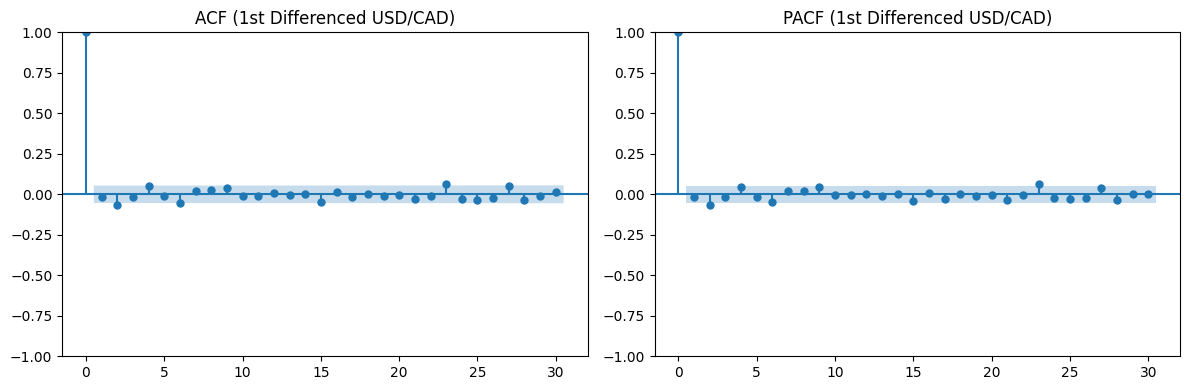


ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                USD_CAD   No. Observations:                 1332
Model:                 ARIMA(1, 1, 1)   Log Likelihood                4970.138
Date:                Mon, 07 Jul 2025   AIC                          -9934.277
Time:                        21:46:14   BIC                          -9918.696
Sample:                             0   HQIC                         -9928.438
                               - 1332                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4217      1.025      0.412      0.681      -1.587       2.430
ma.L1         -0.4379      1.017     -0.430      0.667      -2.432       1.556
sigma2      3.339e-05   9.23e-

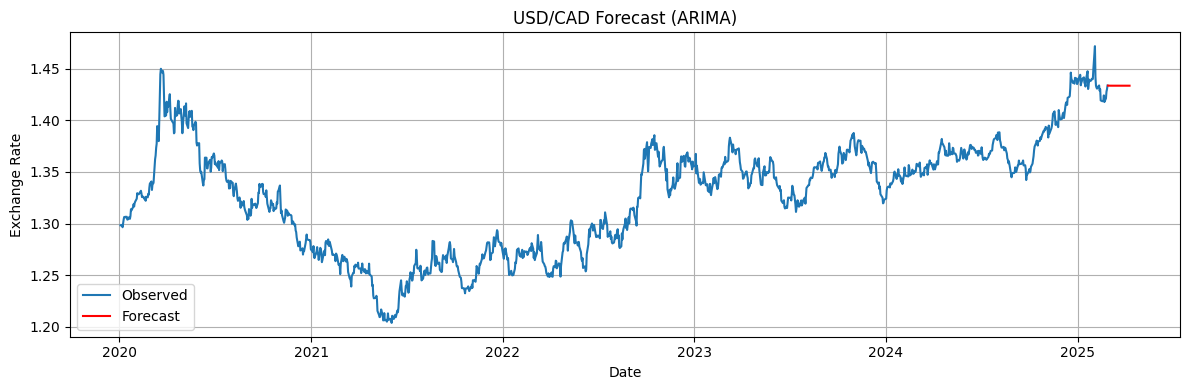

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")



df.sort_index(inplace=True)


ts = df['USD_CAD']


plt.figure(figsize=(12, 4))
plt.plot(ts, label='USD/CAD')
plt.title("USD/CAD Time Series")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.grid(True)
plt.legend()
plt.show()


def adf_test(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value}")
    if result[1] <= 0.05:
        print("=> Stationary (reject H0)")
    else:
        print("=> Non-stationary (fail to reject H0)")

print("\nADF Test on Original Series:")
adf_test(ts)


ts_diff = ts.diff().dropna()

print("\nADF Test on First-Differenced Series:")
adf_test(ts_diff)


fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(ts_diff, ax=axes[0], lags=30)
plot_pacf(ts_diff, ax=axes[1], lags=30)
axes[0].set_title("ACF (1st Differenced USD/CAD)")
axes[1].set_title("PACF (1st Differenced USD/CAD)")
plt.tight_layout()
plt.show()


model = ARIMA(ts, order=(1, 1, 1))
model_fit = model.fit()


print("\nARIMA Model Summary:")
print(model_fit.summary())


forecast_steps = 30
forecast = model_fit.forecast(steps=forecast_steps)


plt.figure(figsize=(12, 4))
plt.plot(ts, label='Observed')
plt.plot(pd.date_range(start=ts.index[-1], periods=forecast_steps+1, freq='B')[1:], forecast, label='Forecast', color='red')
plt.title("USD/CAD Forecast (ARIMA)")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


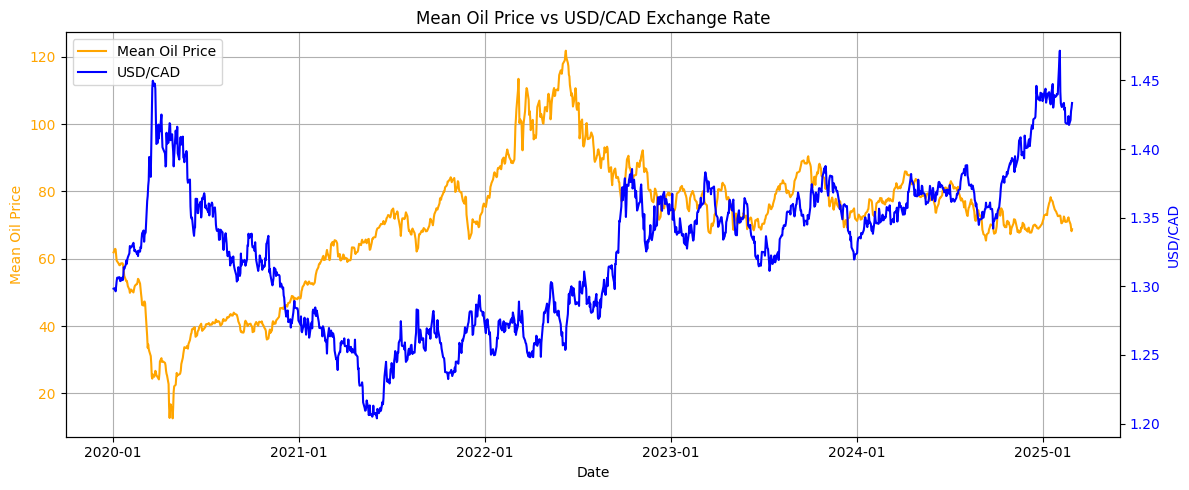

In [ ]:

import matplotlib.dates as mdates

fig, ax1 = plt.subplots(figsize=(12, 5))


ax1.plot(df.index, df['Oil_Price'], label='Mean Oil Price', color='orange')
ax1.set_ylabel('Mean Oil Price', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')

ax2 = ax1.twinx()
ax2.plot(df.index, df['USD_CAD'], label='USD/CAD', color='blue')
ax2.set_ylabel('USD/CAD', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')


ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))


plt.title('Mean Oil Price vs USD/CAD Exchange Rate')
ax1.set_xlabel('Date')
ax1.grid(True)


lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.tight_layout()
plt.show()



===== YEAR: 2020 =====
ADF Test (Original Series):
ADF Statistic: -1.0958113447955906
p-value: 0.7167393985174311
=> Non-stationary


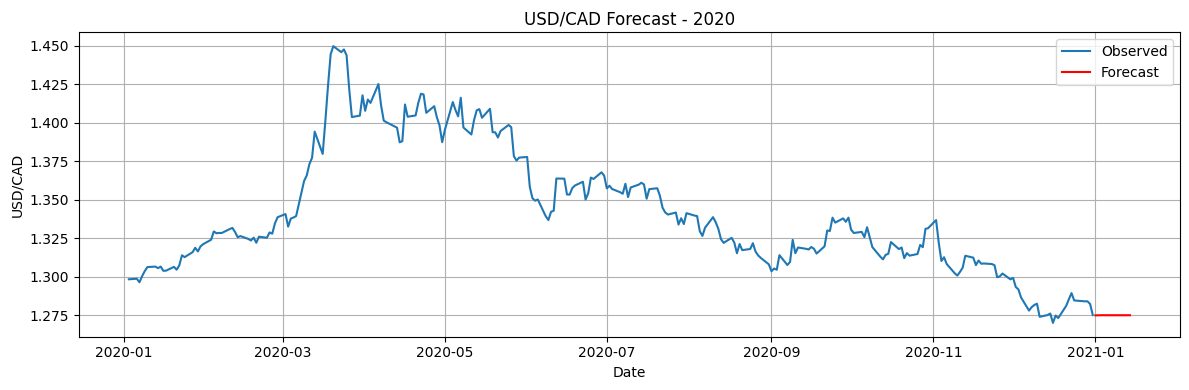


===== YEAR: 2021 =====
ADF Test (Original Series):
ADF Statistic: -1.7041073010295393
p-value: 0.4289975240036432
=> Non-stationary


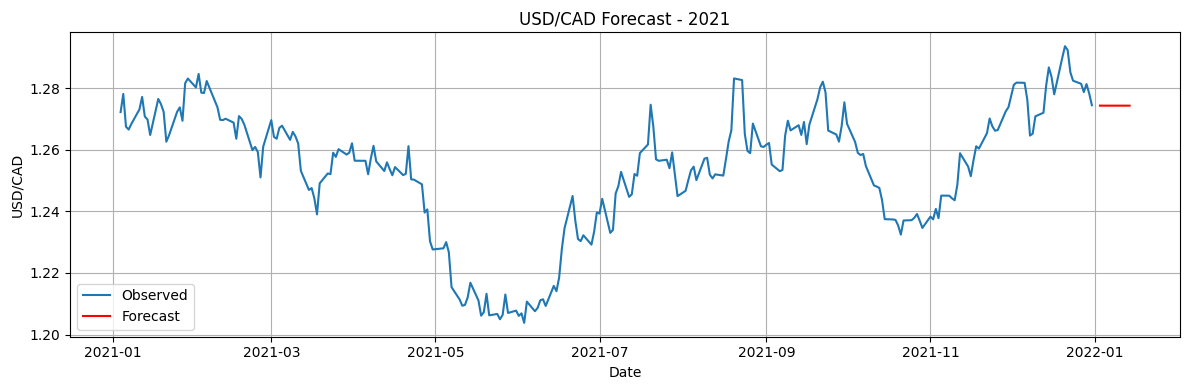


===== YEAR: 2022 =====
ADF Test (Original Series):
ADF Statistic: -1.0666613109744107
p-value: 0.7281822837827618
=> Non-stationary


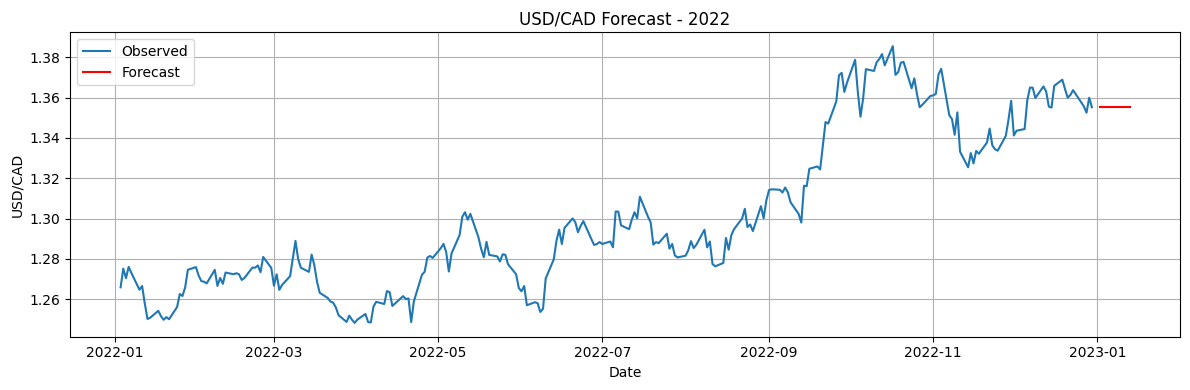


===== YEAR: 2023 =====
ADF Test (Original Series):
ADF Statistic: -2.2707838315133997
p-value: 0.18156393869971849
=> Non-stationary


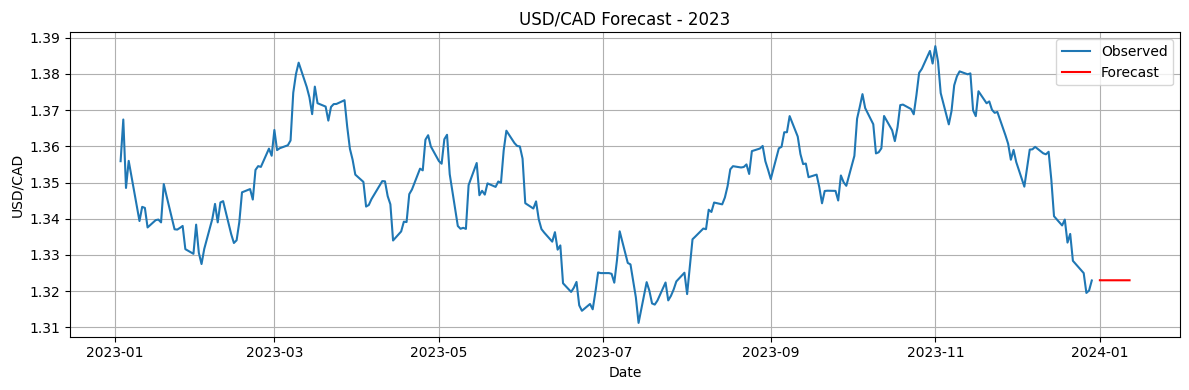


===== YEAR: 2024 =====
ADF Test (Original Series):
ADF Statistic: 0.0412929856696735
p-value: 0.9618166499940614
=> Non-stationary


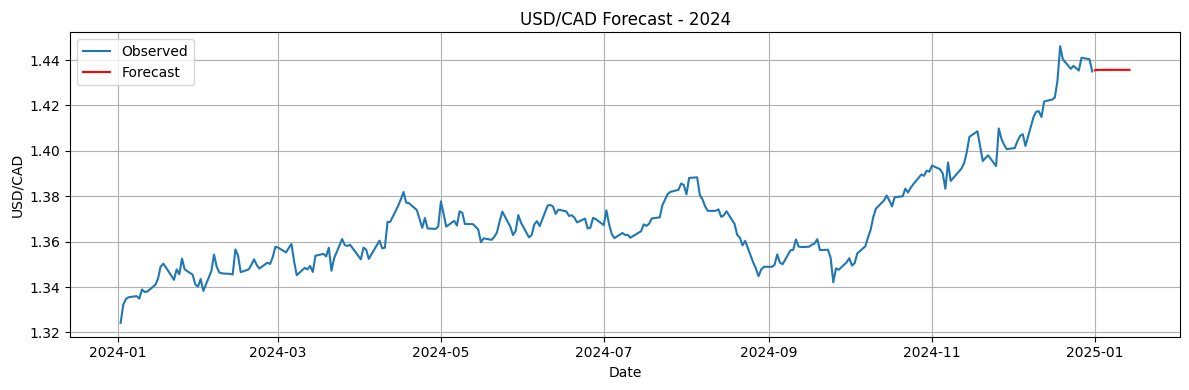


===== YEAR: 2025 =====
ADF Test (Original Series):
ADF Statistic: -2.6673140775196043
p-value: 0.0798671426450761
=> Non-stationary


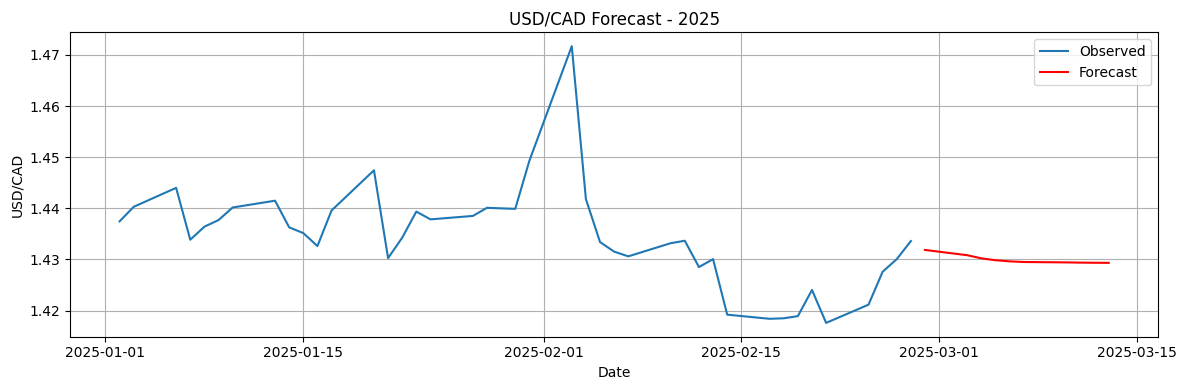

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")



df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)


ts = df['USD_CAD']


for year in sorted(ts.index.year.unique()):
    print(f"\n===== YEAR: {year} =====")


    yearly_data = ts[ts.index.year == year]


    if len(yearly_data) < 30:
        print("Too few data points, skipping...")
        continue


    def adf_test(series):
        result = adfuller(series)
        print("ADF Statistic:", result[0])
        print("p-value:", result[1])
        if result[1] <= 0.05:
            print("=> Stationary")
        else:
            print("=> Non-stationary")

    print("ADF Test (Original Series):")
    adf_test(yearly_data)


    try:
        model = ARIMA(yearly_data, order=(1, 1, 1))
        model_fit = model.fit()


        forecast_steps = min(10, len(yearly_data) - 1)
        forecast = model_fit.forecast(steps=forecast_steps)


        plt.figure(figsize=(12, 4))
        plt.plot(yearly_data, label='Observed')
        plt.plot(pd.date_range(start=yearly_data.index[-1], periods=forecast_steps+1, freq='B')[1:], forecast,
                 label='Forecast', color='red')
        plt.title(f'USD/CAD Forecast - {year}')
        plt.xlabel('Date')
        plt.ylabel('USD/CAD')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"ARIMA failed for {year}: {e}")


ADF Test for Oil_Price:
  ADF Statistic: -1.6296204628059996
  p-value: 0.46768938448417446
  => Non-stationary

ADF Test for USD_CAD:
  ADF Statistic: 0.0412929856696735
  p-value: 0.9618166499940614
  => Non-stationary

ADF Test for Oil_Price (1st diff):
  ADF Statistic: -4.069258152827303
  p-value: 0.001088263514721251
  => Stationary

ADF Test for USD_CAD (1st diff):
  ADF Statistic: -13.242085012926282
  p-value: 9.127970147977977e-25
  => Stationary

. Lag Order Selection:
  VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -11.10      -11.07   1.509e-05      -11.09
1       -11.33      -11.24   1.200e-05      -11.30
2       -11.42      -11.28   1.098e-05      -11.36
3       -11.44      -11.24   1.075e-05      -11.36
4       -11.54     -11.28*   9.700e-06     -11.44*
5       -11.52      -11.20   9.921e-06      -11.39
6       -11.54      -11.17   9.696e-06      -11.39
7   

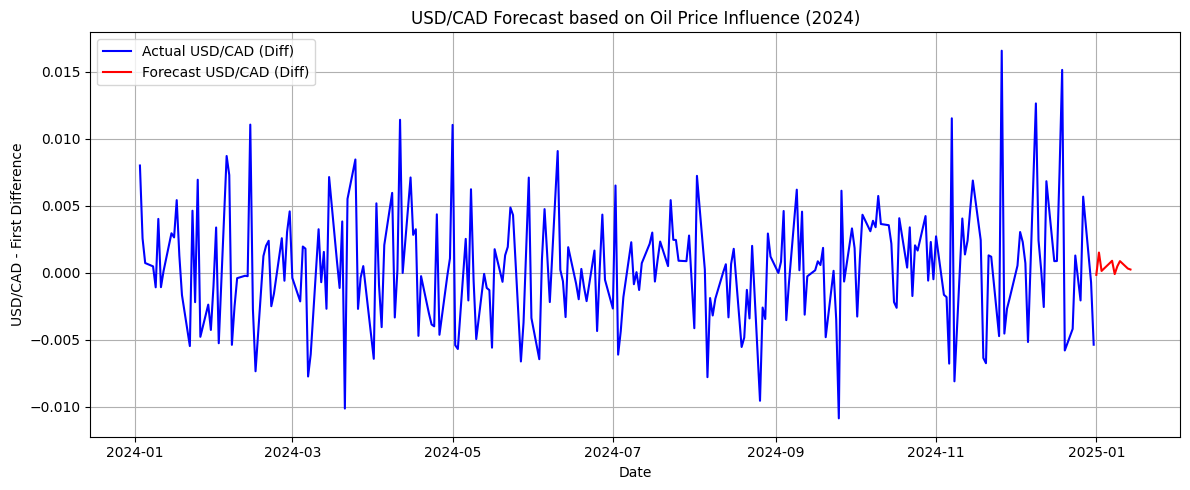

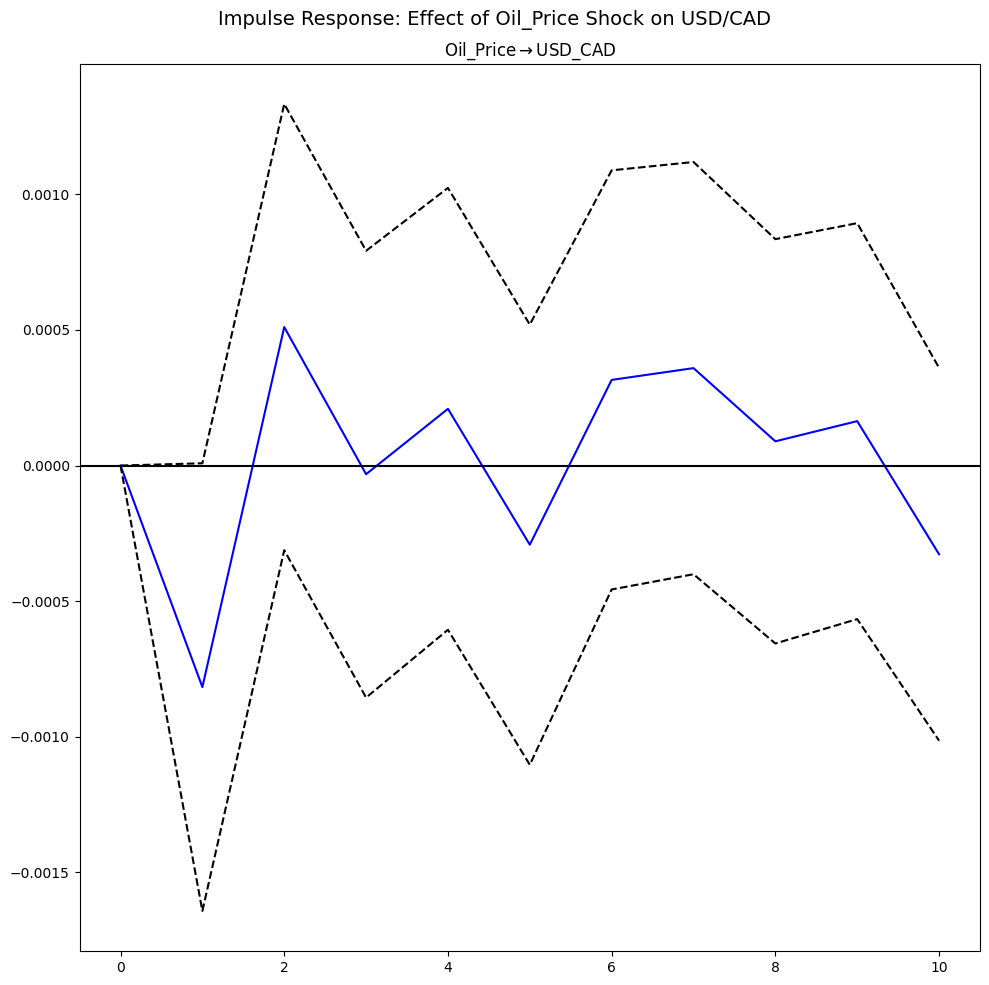

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
import warnings
warnings.filterwarnings("ignore")


df_2024 = df[df.index.year == 2024][['Oil_Price', 'USD_CAD']].dropna()


if len(df_2024) < 30:
    print("Not enough data for 2024 analysis.")
    exit()


def adf_test(series, name):
    result = adfuller(series)
    print(f"ADF Test for {name}:")
    print("  ADF Statistic:", result[0])
    print("  p-value:", result[1])
    if result[1] <= 0.05:
        print("  => Stationary")
    else:
        print("  => Non-stationary")
    print("")


adf_test(df_2024['Oil_Price'], "Oil_Price")
adf_test(df_2024['USD_CAD'], "USD_CAD")


df_diff = df_2024.diff().dropna()

adf_test(df_diff['Oil_Price'], "Oil_Price (1st diff)")
adf_test(df_diff['USD_CAD'], "USD_CAD (1st diff)")


model = VAR(df_diff)
lag_selection = model.select_order(maxlags=15)
print(". Lag Order Selection:\n", lag_selection.summary())


lag = lag_selection.selected_orders['aic'] or 1
results = model.fit(lag)

print(results.summary())

forecast_steps = 10
forecast = results.forecast(df_diff.values[-lag:], steps=forecast_steps)


forecast_df = pd.DataFrame(forecast, columns=['Oil_Price_forecast', 'USD_CAD_forecast'])
forecast_df.index = pd.date_range(start=df_diff.index[-1], periods=forecast_steps+1, freq='B')[1:]

plt.figure(figsize=(12, 5))
plt.plot(df_diff['USD_CAD'], label='Actual USD/CAD (Diff)', color='blue')
plt.plot(forecast_df['USD_CAD_forecast'], label='Forecast USD/CAD (Diff)', color='red')
plt.title('USD/CAD Forecast based on Oil Price Influence (2024)')
plt.xlabel('Date')
plt.ylabel('USD/CAD - First Difference')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


irf = results.irf(10)
irf.plot(orth=False, impulse='Oil_Price', response='USD_CAD')
plt.suptitle("Impulse Response: Effect of Oil_Price Shock on USD/CAD", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd



df = df[['Oil_Price', 'USD_CAD']].dropna()

yearly_corr = df.groupby(df.index.year).apply(lambda x: x['Oil_Price'].corr(x['USD_CAD']))
strongest_year = yearly_corr.abs().idxmax()
strongest_corr = yearly_corr[strongest_year]
weakest_year = yearly_corr.abs().idxmin()
weakest_corr = yearly_corr[weakest_year]

print("📈 Yearly correlation between oil price and USD/CAD exchange rate:")
print(yearly_corr)

print(f"\n💪 Strongest relationship: {strongest_corr:.4f} in {strongest_year}")
print(f"📉 Weakest relationship: {weakest_corr:.4f} in {weakest_year}")


📈 Yearly correlation between oil price and USD/CAD exchange rate:
Date
2020   -0.807042
2021   -0.236108
2022   -0.568799
2023    0.201629
2024   -0.335023
2025    0.365399
dtype: float64

💪 Strongest relationship: -0.8070 in 2020
📉 Weakest relationship: 0.2016 in 2023


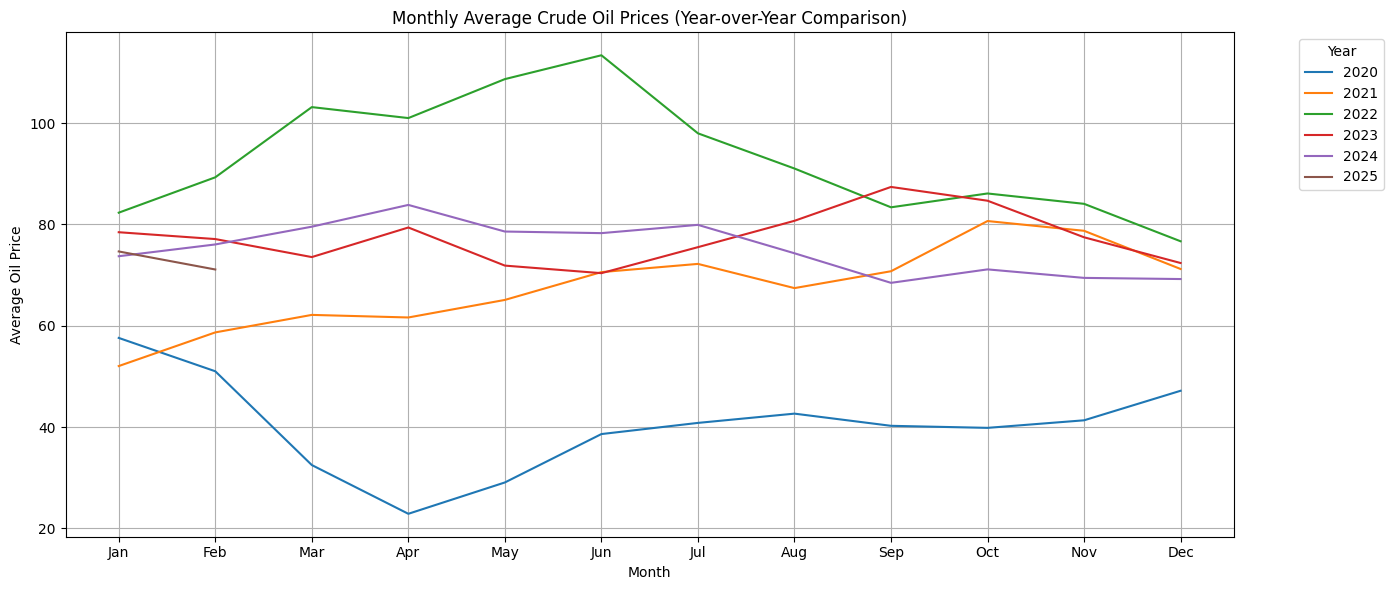

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


df = df[['Oil_Price']].dropna()


df['Year'] = df.index.year
df['Month'] = df.index.month


monthly_avg = df.groupby(['Year', 'Month'])['Oil_Price'].mean().unstack(0)

plt.figure(figsize=(14, 6))
for year in monthly_avg.columns:
    plt.plot(monthly_avg.index, monthly_avg[year], label=str(year))


plt.title('Monthly Average Crude Oil Prices (Year-over-Year Comparison)')
plt.xlabel('Month')
plt.ylabel('Average Oil Price')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


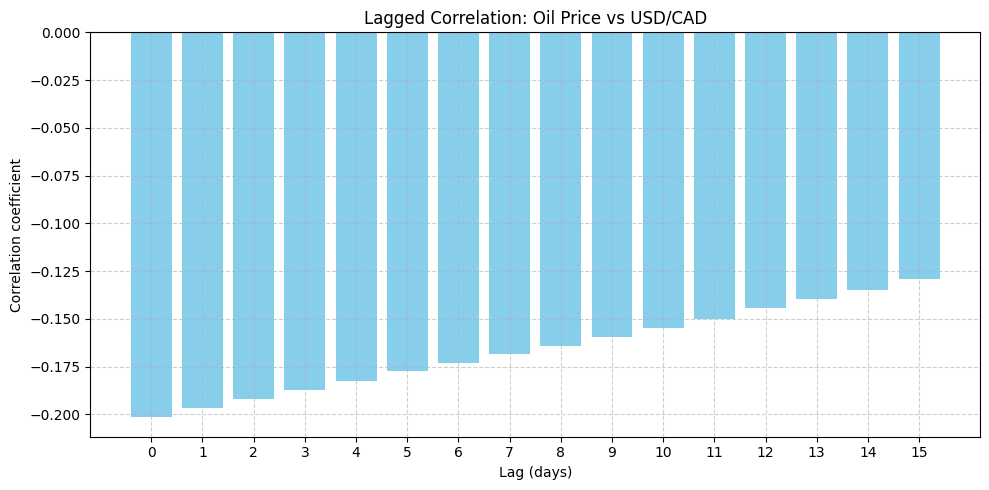

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


df = df.sort_index()


lags = list(range(16))  #
correlations = []

for lag in lags:
    shifted_oil = df['Oil_Price'].shift(lag)
    corr = df['USD_CAD'].corr(shifted_oil)
    correlations.append(corr)

lag_df = pd.DataFrame({
    'Lag (days)': lags,
    'Correlation': correlations
})


plt.figure(figsize=(10, 5))
plt.bar(lag_df['Lag (days)'], lag_df['Correlation'], color='skyblue')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Lagged Correlation: Oil Price vs USD/CAD')
plt.xlabel('Lag (days)')
plt.ylabel('Correlation coefficient')
plt.xticks(lags)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


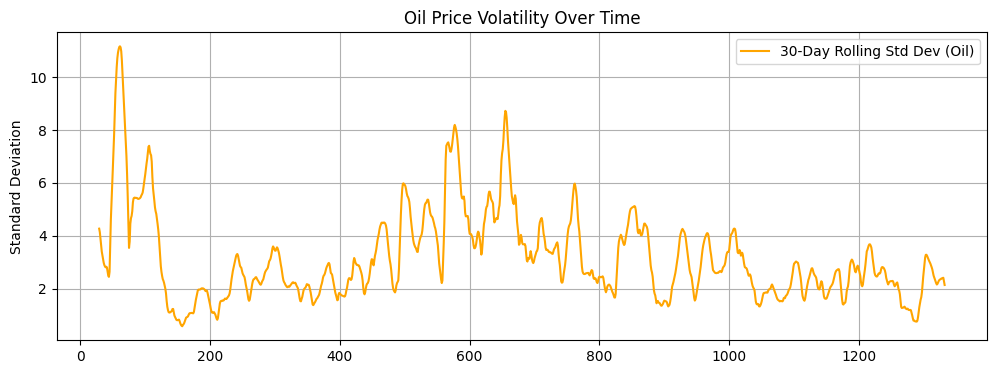

In [ ]:
rolling_std = df['Oil_Price'].rolling(window=30).std()
plt.figure(figsize=(12, 4))
plt.plot(df.index, rolling_std, label='30-Day Rolling Std Dev (Oil)', color='orange')
plt.title('Oil Price Volatility Over Time')
plt.ylabel('Standard Deviation')
plt.grid(True)
plt.legend()
plt.show()


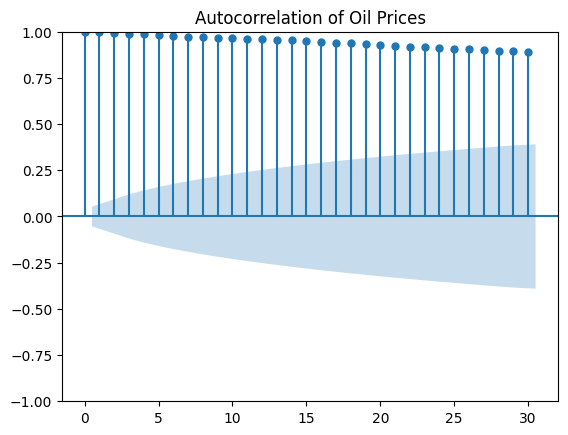

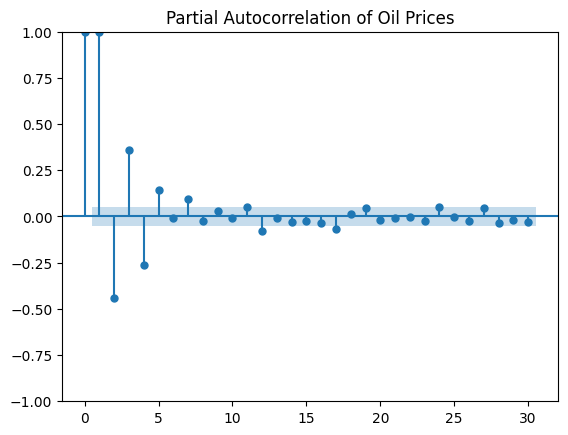

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['Oil_Price'].dropna(), lags=30)
plt.title('Autocorrelation of Oil Prices')
plt.show()

plot_pacf(df['Oil_Price'].dropna(), lags=30)
plt.title('Partial Autocorrelation of Oil Prices')
plt.show()


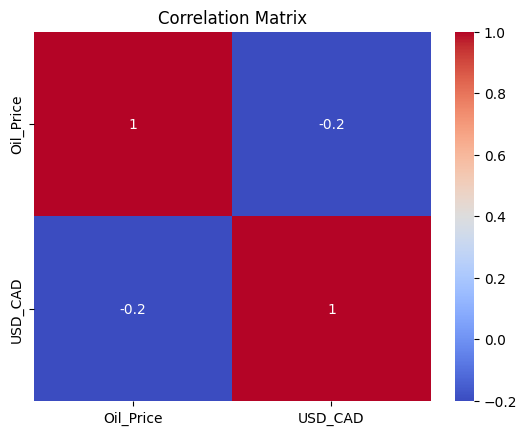

In [ ]:
import seaborn as sns

sns.heatmap(df[['Oil_Price', 'USD_CAD']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


/tmp/ipython-input-2197411112.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  fx_data = yf.download(tickers, start=start_date, end=end_date)['Close']
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed
/tmp/ipython-input-2197411112.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  fx_data.fillna(method='ffill', inplace=True)


Data downloaded and cleaned successfully.

--- Canadian Dollar Index (CAD Index) ---
             CAD_Index
Date                  
2020-01-01  100.000000
2020-01-02  100.254264
2020-01-03  100.459052
2020-01-06  100.457794
2020-01-07  100.451494


            CAD_Index
Date                 
2025-03-24  96.125592
2025-03-25  96.430550
2025-03-26  96.615208
2025-03-27  96.746631
2025-03-28  96.432785


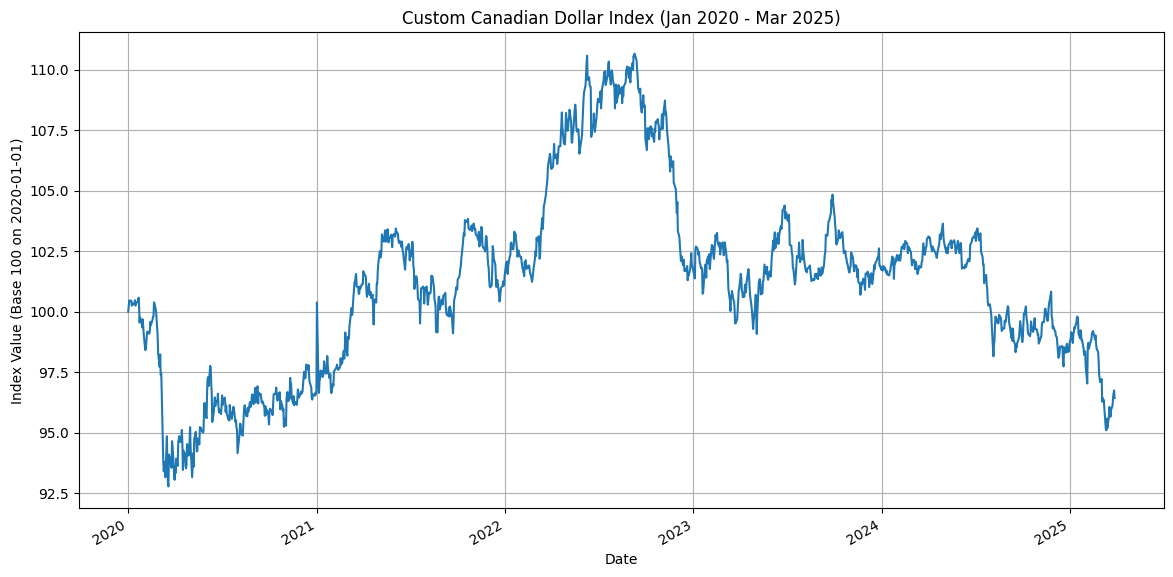

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Define Parameters ---
# Set the start and end dates for the data download.
start_date = '2020-01-01'
end_date = '2025-03-31'

# Define the Yahoo Finance tickers for the currencies needed.
tickers = [
    'CADUSD=X',  # Canadian Dollar to USD
    'EURUSD=X',  # Euro to USD
    'GBPUSD=X',  # British Pound to USD
    'JPYUSD=X',  # Japanese Yen to USD
    'CHFUSD=X'   # Swiss Franc to USD
]

# --- 2. Download Exchange Rate Data ---
# Fetch the 'Close' price for each ticker from Yahoo Finance.
print("Downloading currency data...")
# CORRECTED LINE: Changed 'Adj Close' to 'Close'
fx_data = yf.download(tickers, start=start_date, end=end_date)['Close']

# --- 3. Clean and Prepare Data ---
# Forward-fill any missing values (e.g., for weekends/holidays).
fx_data.fillna(method='ffill', inplace=True)

# Rename columns for easier access.
fx_data.rename(columns={
    'CADUSD=X': 'CAD_USD',
    'EURUSD=X': 'EUR_USD',
    'GBPUSD=X': 'GBP_USD',
    'JPYUSD=X': 'JPY_USD',
    'CHFUSD=X': 'CHF_USD'
}, inplace=True)

print("Data downloaded and cleaned successfully.")

# --- 4. Calculate CAD Cross-Currency Rates ---
# Use the USD rates to calculate the value of CAD against other currencies.
df = pd.DataFrame(index=fx_data.index)
df['CAD_USD'] = fx_data['CAD_USD']
df['CAD_EUR'] = fx_data['CAD_USD'] / fx_data['EUR_USD']
df['CAD_GBP'] = fx_data['CAD_USD'] / fx_data['GBP_USD']
df['CAD_JPY'] = fx_data['CAD_USD'] / fx_data['JPY_USD']
df['CAD_CHF'] = fx_data['CAD_USD'] / fx_data['CHF_USD']

# --- 5. Construct the CAD Index ---
# Normalize each cross-rate series to a base of 1.0 on the start date.
normalized_basket = df.div(df.iloc[0])

# Define equal weights for our 5-currency basket.
weights = [0.20, 0.20, 0.20, 0.20, 0.20]

# Calculate the weighted geometric mean and scale it to start at 100.
cad_index = 100 * (normalized_basket ** weights).prod(axis=1)

# Create a final DataFrame for the index.
cad_index_df = pd.DataFrame(cad_index, columns=['CAD_Index'])

# --- 6. Display and Plot the Final Index ---
print("\n--- Canadian Dollar Index (CAD Index) ---")
print(cad_index_df.head())
print("\n")
print(cad_index_df.tail())

# Plot the resulting index to visualize it.
cad_index_df['CAD_Index'].plot(
    title='Custom Canadian Dollar Index (Jan 2020 - Mar 2025)',
    figsize=(14, 7),
    grid=True
)
plt.ylabel('Index Value (Base 100 on 2020-01-01)')
plt.show()


Oil and FX data successfully merged.
        Date  Close   Open  Oil_Price   CAD_Index
0 2020-01-03  62.82  60.95     61.885  100.459052
1 2020-01-06  63.04  62.82     62.930  100.457794
2 2020-01-07  62.51  63.04     62.775  100.451494
3 2020-01-08  59.46  62.51     60.985  100.246687
4 2020-01-09  59.44  59.46     59.450  100.355247

--- Descriptive Statistics (Corrected) ---
         Oil_Price    CAD_Index
count  1333.000000  1333.000000
mean     70.837914   101.267402
std      18.975342     3.708421
min      12.560000    92.781133
25%      63.365000    99.044587
50%      73.280000   101.495163
75%      81.010000   102.859670
max     121.810000   110.658479

--- Correlation Matrix (Corrected) ---
           Oil_Price  CAD_Index
Oil_Price   1.000000   0.871246
CAD_Index   0.871246   1.000000

Generating time series plot...
Generating scatter plot...
Generating histograms...
Generating correlation heatmap...
Displaying plots...


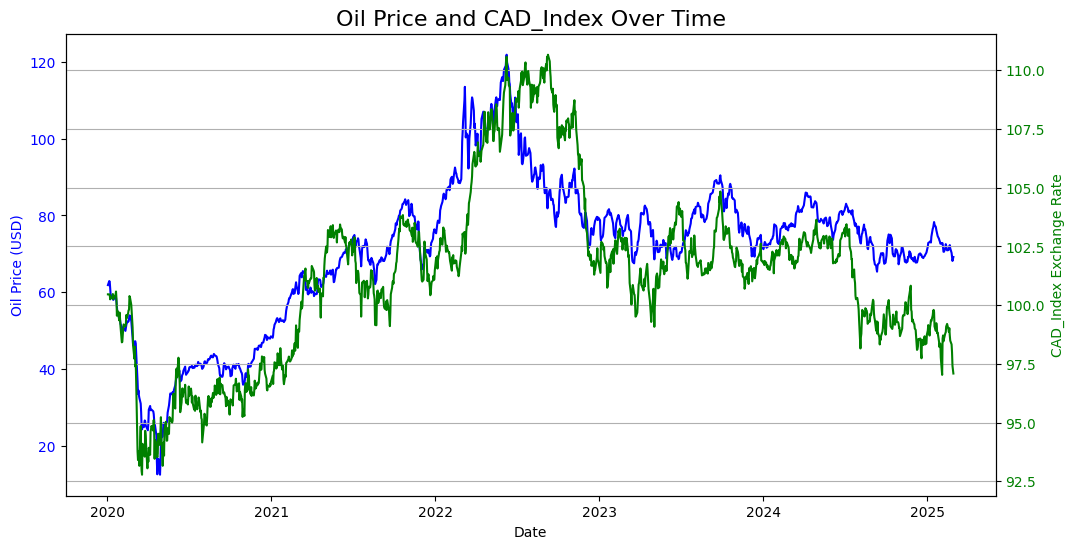

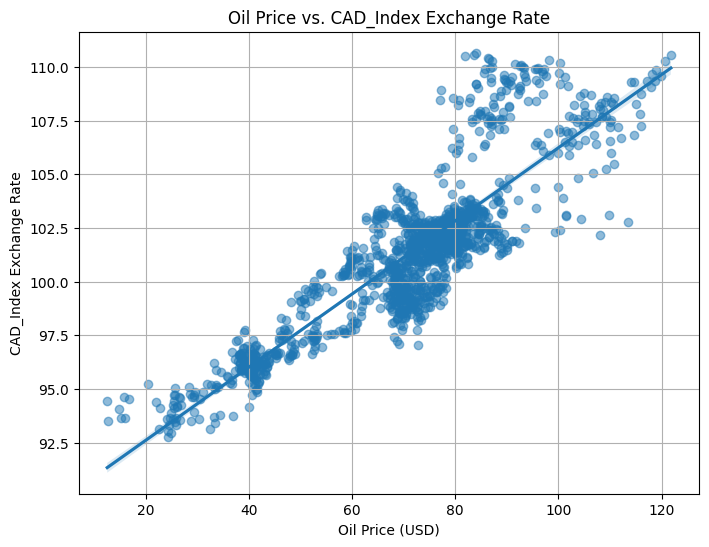

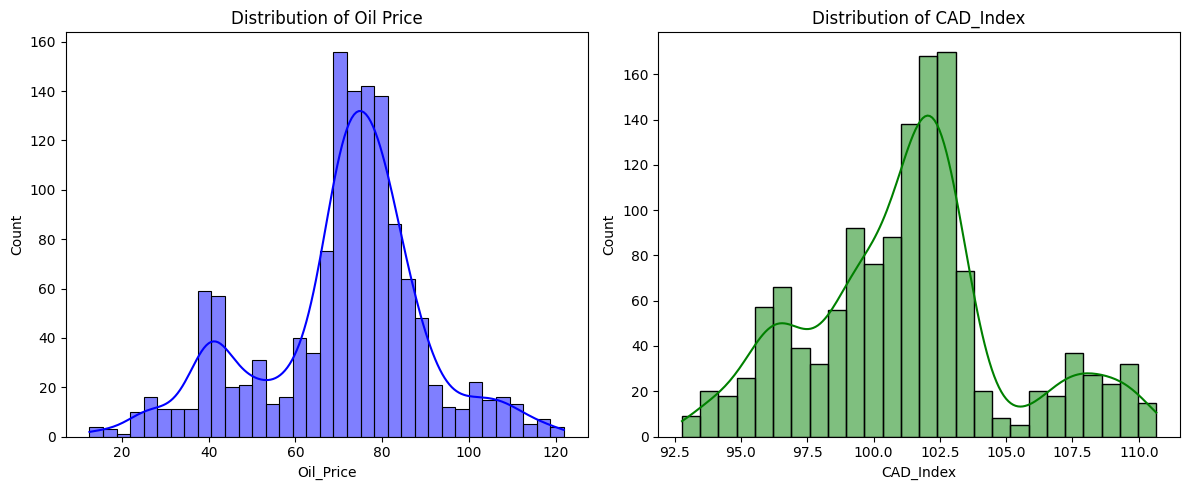

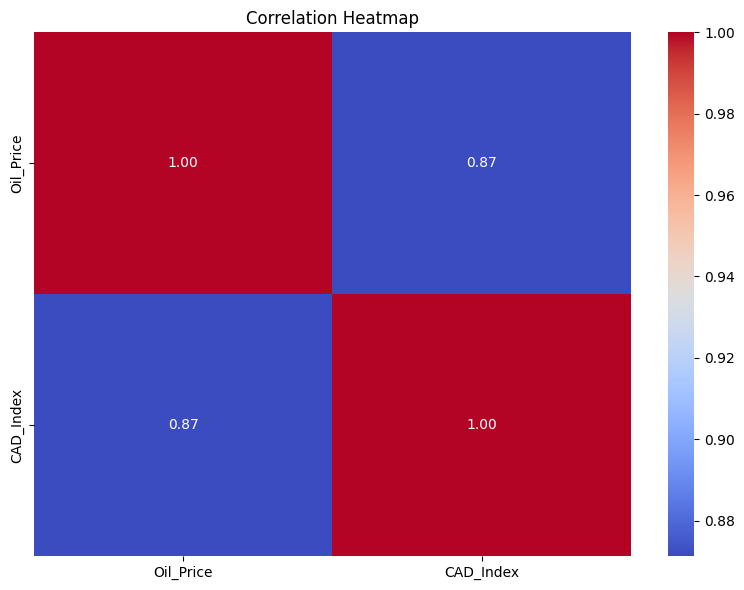

In [ ]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load and Process Raw Oil Data ---


# --- 2. Fetch FX Data ---
# print("Downloading USD/CAD exchange rate data...")
# start_date = oil_df['Date'].min().strftime('%Y-%m-%d')
# end_date = oil_df['Date'].max().strftime('%Y-%m-%d')
# fx_data = yf.download("USDCAD=X", start=start_date, end=end_date)
# fx_data = fx_data[['Close']].reset_index()
# fx_data.columns = ['Date', 'USD_CAD']
# print("Download complete.")

# --- 3. Merge Oil and FX Data ---
# This is the crucial step to combine both datasets
final_df = pd.merge(oil_df, cad_index_df, on='Date', how='inner')
print("\nOil and FX data successfully merged.")
print(final_df.head())
# --- 4. Perform Data Analysis on the Correct DataFrame ---
print("\n--- Descriptive Statistics (Corrected) ---")
print(final_df[['Oil_Price', 'CAD_Index']].describe())

print("\n--- Correlation Matrix (Corrected) ---")
print(final_df[['Oil_Price', 'CAD_Index']].corr())

# --- 5. Generate Visualizations ---
# Plot 1: Time Series of Oil Price and USD/CAD
print("\nGenerating time series plot...")
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.set_title('Oil Price and CAD_Index Over Time', fontsize=16)
ax1.set_xlabel('Date')
ax1.set_ylabel('Oil Price (USD)', color='blue')
ax1.plot(final_df['Date'], final_df['Oil_Price'], color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.set_ylabel('CAD_Index Exchange Rate', color='green')
ax2.plot(final_df['Date'], final_df['CAD_Index'], color='green')
ax2.tick_params(axis='y', labelcolor='green')
plt.grid(True)

# Plot 2: Scatter Plot of Oil Price vs. USD/CAD
print("Generating scatter plot...")
plt.figure(figsize=(8, 6))
sns.regplot(x='Oil_Price', y='CAD_Index', data=final_df, scatter_kws={'alpha': 0.5})
plt.title('Oil Price vs. CAD_Index Exchange Rate')
plt.xlabel('Oil Price (USD)')
plt.ylabel('CAD_Index Exchange Rate')
plt.grid(True)

# Plot 3: Distribution Histograms
print("Generating histograms...")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(final_df['Oil_Price'], kde=True, color='blue')
plt.title('Distribution of Oil Price')
plt.subplot(1, 2, 2)
sns.histplot(final_df['CAD_Index'], kde=True, color='green')
plt.title('Distribution of CAD_Index')
plt.tight_layout()

# Plot 4: Correlation Heatmap
print("Generating correlation heatmap...")
plt.figure(figsize=(8, 6))
sns.heatmap(final_df[['Oil_Price', 'CAD_Index']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.tight_layout()

# --- 6. Display All Plots ---
print("Displaying plots...")
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

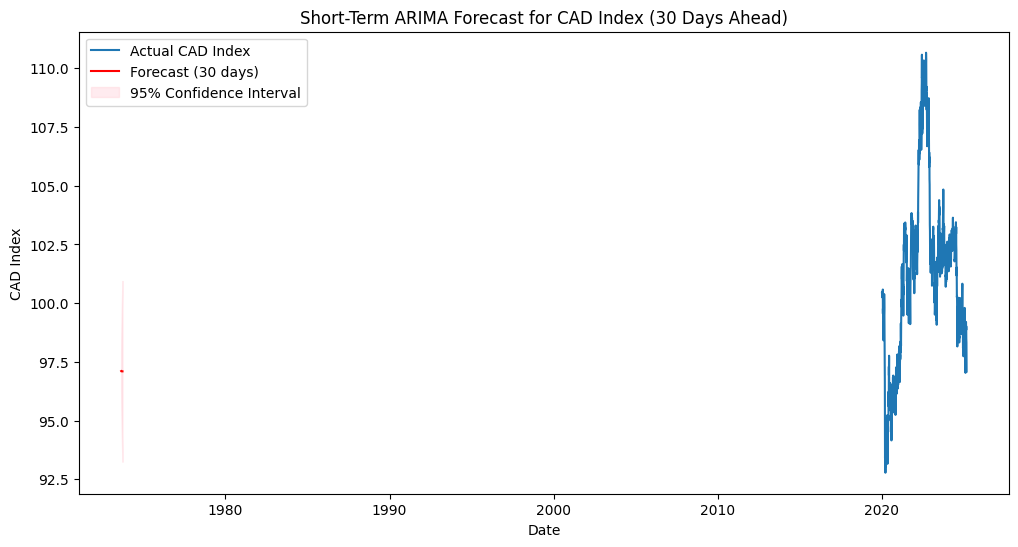

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# -------------------------
# 1. Load Dataset
# -------------------------
# Replace with your actual CSV file name


# Ensure Date is datetime

final_df.set_index('Date', inplace=True)

# -------------------------
# 2. Select CAD Index Series
# -------------------------
# Change 'CAD_Index' to your actual column name
series = final_df['CAD_Index']

# -------------------------
# 3. Fit ARIMA Model
# -------------------------
# You can tune (p,d,q); here (5,1,0) is a common starting point
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit()

# -------------------------
# 4. Forecast Next 30 Days
# -------------------------
forecast_steps = 30
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# -------------------------
# 5. Plot Results
# -------------------------
plt.figure(figsize=(12,6))
plt.plot(series, label="Actual CAD Index")
plt.plot(forecast_mean.index, forecast_mean, label="Forecast (30 days)", color="red")
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:,0],
                 forecast_ci.iloc[:,1],
                 color="pink", alpha=0.3, label="95% Confidence Interval")

plt.title("Short-Term ARIMA Forecast for CAD Index (30 Days Ahead)")
plt.xlabel("Date")
plt.ylabel("CAD Index")
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import yfinance as yf

# This code assumes a DataFrame named 'final_df' already exists.

# --- PART 1: MERGING USD/CAD DATA ---
try:
    # Ensure the 'Date' column is in datetime format
    if not pd.api.types.is_datetime64_any_dtype(final_df['Date']):
        final_df['Date'] = pd.to_datetime(final_df['Date'])

    # Get the date range from your existing DataFrame
    start_date = final_df['Date'].min().strftime('%Y-%m-%d')
    end_date = final_df['Date'].max().strftime('%Y-%m-%d')

    print(f"Fetching USD/CAD data from {start_date} to {end_date}...")
    fx_data = yf.download("USDCAD=X", start=start_date, end=end_date, progress=False)
    fx_data = fx_data[['Close']].reset_index()
    fx_data.columns = ['Date', 'USD_CAD']
    print("Download complete.")

    # Merge the fetched data into your final_df
    final_df = pd.merge(final_df, fx_data, on='Date', how='inner')
    print("Successfully merged USD/CAD data into final_df.")

# --- PART 2: CALCULATING CORRELATIONS FOR TABLE 1 ---
    print("\n--- Correlation Matrix ---")
    # Calculate the correlations from the updated DataFrame
    correlation_matrix = final_df[['Oil_Price', 'USD_CAD', 'CAD_Index']].corr()
    print(correlation_matrix)

    # Extract the specific values for your table
    oil_vs_usdcad = correlation_matrix.loc['Oil_Price', 'USD_CAD']
    oil_vs_cad_index = correlation_matrix.loc['Oil_Price', 'CAD_Index']

    print(f"\nCorrelation for 'Crude Oil Price vs. USD/CAD': {oil_vs_usdcad:.4f}")
    print(f"Correlation for 'Crude Oil Price vs. CAD Index': {oil_vs_cad_index:.4f}")

except NameError:
    print("Error: A DataFrame named 'final_df' was not found.")
except KeyError as e:
    print(f"Error: A required column was not found in the DataFrame: {e}")

Fetching USD/CAD data from 2020-01-03 to 2025-02-28...
Download complete.
Successfully merged USD/CAD data into final_df.

--- Correlation Matrix ---
           Oil_Price   USD_CAD  CAD_Index
Oil_Price   1.000000 -0.198741   0.871590
USD_CAD    -0.198741  1.000000  -0.303105
CAD_Index   0.871590 -0.303105   1.000000

Correlation for 'Crude Oil Price vs. USD/CAD': -0.1987
Correlation for 'Crude Oil Price vs. CAD Index': 0.8716


/tmp/ipython-input-2372506991.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  fx_data = yf.download("USDCAD=X", start=start_date, end=end_date, progress=False)
